In [3]:
import sys
sys.path.append("../abraca-data/data")

In [4]:
import os
cwd = os.getcwd()
cwd

'c:\\Users\\chkla\\Documents\\GitHub\\DMC20_abraca-data-2'

In [5]:
os.getcwd()

'c:\\Users\\chkla\\Documents\\GitHub\\DMC20_abraca-data-2'

In [ ]:
# Load Data

In [32]:
import pandas as pd

df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])

df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()
df_train["time"] = pd.to_datetime(df_train["time"], format='%Y-%m-%d %H:%M:%S')

df_items = pd.read_csv('items.csv', sep='|', index_col='itemID')


df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

FileNotFoundError: [Errno 2] File items.csv does not exist: 'items.csv'

In [7]:
df_train.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [8]:
#create column only containing date
df_train['date'] = df_train['time'].dt.date
df_train.head()

,time,transactID,itemID,order,salesPrice,date
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01


In [9]:
#add up all orders that were made on one day
df_train['sum_sold'] = df_train['order'].groupby(df_train['date']).transform('sum')
df_train.head()

,time,transactID,itemID,order,salesPrice,date,sum_sold
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01,6305
1,2018-01-01 00:01:56,2278968,83,1,5.19,2018-01-01,6305
2,2018-01-01 00:07:11,2255797,7851,2,20.47,2018-01-01,6305
3,2018-01-01 00:09:24,2278968,450,1,17.42,2018-01-01,6305
4,2018-01-01 00:09:24,2278968,83,1,5.19,2018-01-01,6305


In [10]:
#limit data to relevant variables only -> sum_sold and date
seasonal = df_train[["sum_sold", "date"]]
#remove duplicates
df_duplicates_removed = seasonal.drop_duplicates(subset=['sum_sold', 'date'])
df_duplicates_removed.head()
#date to datetime format ?error message?
df_duplicates_removed['date'] = pd.to_datetime(df_duplicates_removed['date'])

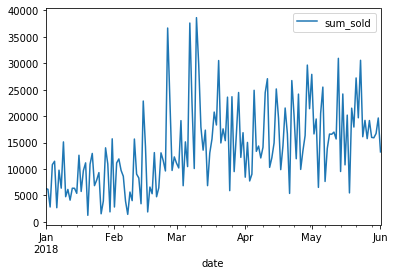

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

#use line plot to visually inspect data for seasonality 
df_duplicates_removed.plot.line(x = 'date', 
             y = 'sum_sold')
plt.show()

#we definetly see a general upward trend

we definetly see a general upward trend

**What kind of seasonalities are relevant for us?**
-Time of Day -> not really relevant if we forecast for a two week period
-Day of the week -> not really relevant if we forecast for a two week period
-Weekly -> relevant
-Monthly -> relevant
-Yearly -> not enough data

**How do we know that an effect is seasonal if we only have data for half a year(periodicity is unknown)?**
**Do we want to correct for seasonality?(No)**


In [12]:
#average number of sold items per day -> 14090,026
df_duplicates_removed.loc[:,"sum_sold"].mean()

#average number of sold items per week

#average number of sold items per month

14090.026315789473

In [13]:
#checking for seasonality in terms of festivities (only those in all parts of Germany):
df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-01-01']
#new years sold: 6305

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-03-30']
#easter friday 12196 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-04-02']
#easter monday 15026 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-01']
#labor day 27885 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-10']
#'christi Himmelfahrt' 16567

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-21']
#pfingsten 27206



,sum_sold,date
1540637,27206,2018-05-21


In [14]:
#exponential smoothing seems to be a thing we could do, note that this doesnt refer to seasonality but to trend
#gives error message
#model = ExponentialSmoothing(df_duplicates_removed, trend="add", seasonal="add", seasonal_periods=6)

## Check for seasonality within the categories

In [15]:
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

In [16]:
df_categories = df_train_joined.drop(['transactID','salesPrice','recommendedRetailPrice','customerRating','simulationPrice','sum_sold','time','promotion','category2','category3','manufacturer','brand','itemID'], axis=1)
df_categories.head()

,order,date,category1
0,1,2018-01-01,1
1,1,2018-01-01,1
2,2,2018-01-01,4
3,1,2018-01-01,1
4,1,2018-01-01,1


In [17]:
df_categories.pivot( columns='category1',values='order')

category1,1,2,3,4,5,6,7,8
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1727359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1727362,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [18]:

#add up all orders that were made on one day


x = df_categories.groupby(['date','category1']).agg('sum')

x.head(20)


order
date       category1       
2018-01-01 1           2153
           2             12
           3             14
           4             84
           5            180
           6            714
           7           3132
           8             16
2018-01-02 1            553
           2             43
           3              7
           4           3496
           5           1715
           6             16
           7             74
           8            261
2018-01-03 1           1893
           2             41
           3             92
           4            126

In [19]:
x = x.unstack(level=1)

In [20]:
type(x)

pandas.core.frame.DataFrame

In [21]:
x.shape

(152, 8)

In [41]:
x.head(20)

order                                          
category1      1     2     3     4      5     6     7    8
date                                                      
2018-01-01  2153    12    14    84    180   714  3132   16
2018-01-02   553    43     7  3496   1715    16    74  261
2018-01-03  1893    41    92   126     58    82   407  122
2018-01-04  1027    23  1147  1081    474  3632  2992  443
2018-01-05   320   898   315   168   7467    56  1921  320
2018-01-06   667    18    38   734     88    23   862  253
2018-01-07   592   163   718    96   4666  3170    50  325
2018-01-08   174    62    12   379    675    34  4947   97
2018-01-09   981   594     4   429  12097    29   766  221
2018-01-10   823    90     7  3063    111    33    63  576
2018-01-11   187   473  3177   940     79  1005   219   61
2018-01-12  1776    40   631  1393    192    15    47   23
2018-01-13   337    14    32  2334   3504     9    52   87
2018-01-14   801    12   167   374     68    17  4827   89
2018-01-15   464    11   895  1323   1149   745   590  228
2018-01-16  2362    19  1132   109   6803  1686   402   88
2018-01-17  1818  2489    26   548     90    16   256  518
2018-01-18  8931    40    12   208    153    50    86  230
2018-01-19   373    48     5  9599   1030    15    42   48
2018-01-20    75    15     9   110     42    14    39  945

In [22]:
x.reset_index(level=0, inplace=True)

In [23]:
for col in x.columns: 
    print(col) 

('date', '')
('order', 1)
('order', 2)
('order', 3)
('order', 4)
('order', 5)
('order', 6)
('order', 7)
('order', 8)


In [24]:
x.rename(columns={'test[1]':'test1'
                          }, 
                 inplace=True)
for col in x.columns: 
    print(col) 

('date', '')
('order', 1)
('order', 2)
('order', 3)
('order', 4)
('order', 5)
('order', 6)
('order', 7)
('order', 8)


In [25]:
x.index

RangeIndex(start=0, stop=152, step=1)

In [26]:
x.index

RangeIndex(start=0, stop=152, step=1)

In [27]:
a = x.iloc[:, 2]
print(a)

0         12
1         43
2         41
3         23
4        898
       ...  
147      430
148     1471
149    15956
150     2054
151     2209
Name: (order, 2), Length: 152, dtype: int64


In [28]:
x.columns = x.columns.get_level_values(0)
x.columns

Index(['date', 'order', 'order', 'order', 'order', 'order', 'order', 'order',
       'order'],
      dtype='object')

In [30]:
x.columns = ['date', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8']
for col in x.columns: 
    print(col) 

date
c1
c2
c3
c4
c5
c6
c7
c8


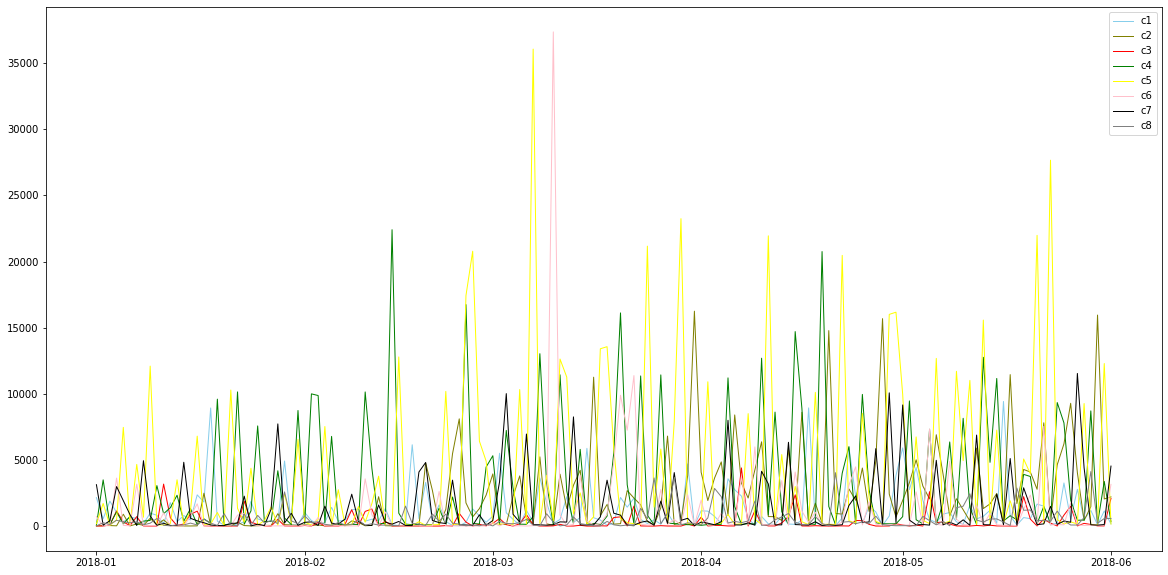

In [42]:
plt.figure(figsize=(20,10))
figure = plt.plot( 'date', 'c1', data=x, color='skyblue', linewidth=1)
plt.plot( 'date', 'c2', data=x, color='olive', linewidth=1)
plt.plot( 'date', 'c3', data=x, color='red', linewidth=1)
plt.plot( 'date', 'c4', data=x, color='green', linewidth=1)
plt.plot( 'date', 'c5', data=x, color='yellow', linewidth=1)
plt.plot( 'date', 'c6', data=x, color='pink', linewidth=1)
plt.plot( 'date', 'c7', data=x, color='black', linewidth=1)
plt.plot( 'date', 'c8', data=x, color='grey', linewidth=1)
plt.legend()


In [47]:
df_categories_days = x

In [49]:
df_categories_days['date']= pd.to_datetime(df_categories_days['date'], format='%Y-%m-%d')

In [50]:
df_categories_days

,date,c1,c2,c3,c4,c5,c6,c7,c8
0,2018-01-01,2153,12,14,84,180,714,3132,16
1,2018-01-02,553,43,7,3496,1715,16,74,261
2,2018-01-03,1893,41,92,126,58,82,407,122
3,2018-01-04,1027,23,1147,1081,474,3632,2992,443
4,2018-01-05,320,898,315,168,7467,56,1921,320
...,...,...,...,...,...,...,...,...,...
147,2018-05-28,502,430,207,457,9267,51,4410,648
148,2018-05-29,1187,1471,124,8711,109,73,103,4122
149,2018-05-30,98,15956,20,180,90,66,75,218
150,2018-05-31,1144,2054,17,3378,12291,68,117,572


In [58]:
import datetime as dt
week_df = df_categories_days.groupby(df_categories_days['date'].dt.weekday).mean()
print (week_df)

c1           c2          c3           c4           c5  \
date                                                                   
0     1481.409091  1911.727273  172.954545  2825.272727  5622.863636   
1     1563.727273  1924.954545  303.136364  2871.772727  2310.863636   
2     1139.636364  2092.727273   72.272727  3345.227273  6550.590909   
3     1721.909091  1880.454545  355.136364  4339.818182  3536.954545   
4     1337.045455  2998.500000  226.272727  2431.000000  1545.681818   
5      703.857143  3484.619048  673.380952  2197.476190  2294.333333   
6      607.476190  1769.714286  337.666667  3698.238095  7156.809524   

               c6           c7          c8  
date                                        
0      980.136364  1191.909091  401.636364  
1     1438.409091  1873.772727  625.090909  
2      799.954545   567.636364  538.454545  
3     1003.590909  1008.545455  363.954545  
4      458.090909   998.954545  674.909091  
5     2770.285714  1450.952381  535.666667  
6     

In [69]:
week_df


,c1,c2,c3,c4,c5,c6,c7,c8
date,,,,,,,,
0,1481.409091,1911.727273,172.954545,2825.272727,5622.863636,980.136364,1191.909091,401.636364
1,1563.727273,1924.954545,303.136364,2871.772727,2310.863636,1438.409091,1873.772727,625.090909
2,1139.636364,2092.727273,72.272727,3345.227273,6550.590909,799.954545,567.636364,538.454545
3,1721.909091,1880.454545,355.136364,4339.818182,3536.954545,1003.590909,1008.545455,363.954545
4,1337.045455,2998.500000,226.272727,2431.000000,1545.681818,458.090909,998.954545,674.909091
5,703.857143,3484.619048,673.380952,2197.476190,2294.333333,2770.285714,1450.952381,535.666667
6,607.476190,1769.714286,337.666667,3698.238095,7156.809524,723.904762,2488.238095,391.714286


In [73]:
type(week_df)

pandas.core.frame.DataFrame

In [74]:
week_df.index.to_numpy()
week_df[col].to_numpy()

array([401.63636364, 625.09090909, 538.45454545, 363.95454545,
       674.90909091, 535.66666667, 391.71428571])

In [75]:
plt.figure(figsize=(20,10))
figure = plt.plot( 'date','c1', data=week_df, color='skyblue', linewidth=1)
#plt.plot( 'date', 'c2', data=x, color='olive', linewidth=1)
#plt.plot( 'date', 'c3', data=x, color='red', linewidth=1)
#plt.plot( 'date', 'c4', data=x, color='green', linewidth=1)
#plt.plot( 'date', 'c5', data=x, color='yellow', linewidth=1)
#plt.plot( 'date', 'c6', data=x, color='pink', linewidth=1)
#plt.plot( 'date', 'c7', data=x, color='black', linewidth=1)
#plt.plot( 'date', 'c8', data=x, color='grey', linewidth=1)
plt.legend()


ValueError: x and y must have same first dimension, but have shapes (1,) and (7,)

In [64]:
week_df.shape

(7, 8)